In [20]:
import deribit_data as dm
import pandas as pd
import numpy as np
import datetime
import json
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Définitions de fonctions

Commençons par définir un certain nombre de fonctions utiles pour le traitement de la donnée, il sagit essentiellement de fonctions pour la conversion entre dates et timestamp

In [83]:
def somme_ponderee(X):
    """
    Input: str représentant une liste de listes de floats = '[[a1,b1],[a2,b2],...,[an,bn]]'
    Output: (Somme des ak*bk) / (Somme des bk)
    """
    s = 0
    d = 0
    
    for x in json.loads(X):

        if len(x)<2:
            return 0.0
        s += x[0]*x[1]
        d += x[1]
    if d!= 0:
        s/= d
    else:
        return 0.0
    return s

def string_to_dict(s):
    """
    Input: str représentant un dictionnaire
    Output: Le dit dictionnaire
    """
    json_acceptable_string = s.replace("'", "\"").replace("None","0.0")
    return json.loads(json_acceptable_string)

def to_date(ts):
    """
    Input: timestamp = nombre de secondes depuis le 01/01/1970
    Output: date
    """
    return str(datetime.datetime.fromtimestamp(ts))


def to_ts(date):
    """
    Input: Date, au format {dd/mm/yy, yy-mm-dd, 13DEC21}
    Output: timestamp en secondes
    """

    
    if '/' in date: #Format dd/mm/yy
        return int(time.mktime(datetime.datetime.strptime(date, "%d/%m/%Y").timetuple()))
    elif '-' in date: #Format yy-mm-dd
        return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()))
    else: # FORMAT 13DEC21
        if len(date)<7:
            date = '0'+date

            
        day = date[:2]
        year = date[-2:]
        month = date[2:-2]

        month_d = { 'JAN':'01',
                    'FEB':'02',
                    'MAR':'03',
                    'APR':'04',
                    'MAY':'05',
                    'JUN':'06',
                    'JUL':'07',
                    'AUG':'08',
                    'SEP':'09',
                    'OCT':'10',
                    'NOV':'11',
                    'DEC':'12'}


        return to_ts(day+'/'+month_d[month]+'/20'+year)
    
def ms_to_s(ts):
    """
    Input: timestamp en ms
    Outpu: timestamp en s
    """
    return int(ts/1000)

def ts_to_days(ts):
    """
    Input: timestamp en s
    Output: nombre de jours, float
    """
    return ts/(3600*24)


# Data processing
## 1 - Récupération de la data sur Deribit

In [2]:
#btc_data = dm.Options("BTC")
#btc_data.collect_data(save_csv=True)




Data Collected


,underlying_price,underlying_index,timestamp,stats,state,open_interest,min_price,max_price,mark_price,mark_iv,...,bids,bid_iv,best_bid_price,best_bid_amount,best_ask_price,best_ask_amount,asks,ask_iv,settlement_price,option_type
0,36904.85,SYN.BTC-2JUL21,1623313079928,"{'volume': None, 'price_change': None, 'low': ...",open,0.0,0.0100,0.0855,0.037121,86.03,...,"[[0.0355, 6.4], [0.0275, 0.4]]",84.15,0.0355,6.4,0.0385,6.4,"[[0.0385, 6.4]]",87.63,NaN,C
1,37556.00,BTC-24SEP21,1623313077916,"{'volume': 2.2, 'price_change': -18.6777, 'low...",open,563.7,0.1695,0.3375,0.240010,93.73,...,"[[0.2385, 0.6], [0.238, 0.6], [0.236, 0.3], [0...",93.04,0.2385,0.6,0.2435,0.3,"[[0.2435, 0.3], [0.246, 0.5], [0.2465, 0.5], [...",95.39,0.24,P
2,36840.51,BTC-18JUN21,1623313077912,"{'volume': None, 'price_change': None, 'low': ...",open,0.0,0.3005,0.3570,0.323590,142.37,...,"[[0.1835, 2.5]]",0.00,0.1835,2.5,0.4240,2.5,"[[0.424, 2.5]]",476.11,0.33,C
3,36872.47,BTC-25JUN21,1623313079930,"{'volume': 240.1, 'price_change': -59.1837, 'l...",open,2139.6,0.0001,0.0445,0.010812,112.15,...,"[[0.01, 16.1], [0.0095, 15.0], [0.0085, 16.0],...",109.70,0.0100,16.1,0.0115,35.2,"[[0.0115, 35.2], [0.012, 14.4], [0.0135, 16.0]...",114.18,0.01,P
4,36872.67,BTC-25JUN21,1623313077916,"{'volume': 2.2, 'price_change': -0.0532, 'low'...",open,46.9,0.7905,0.9125,0.845114,125.50,...,"[[0.8405, 0.3]]",0.00,0.8405,0.3,0.8480,0.3,"[[0.848, 0.3]]",153.13,0.84,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,37585.50,BTC-24SEP21,1623313133310,"{'volume': 0.1, 'price_change': 0.0, 'low': 0....",open,337.6,0.4845,0.6715,0.562783,93.05,...,"[[0.4895, 10.0], [0.001, 5.0], [0.0005, 0.1]]",0.00,0.4895,10.0,6.0000,10.0,"[[6.0, 10.0]]",500.00,0.56,P
402,36846.16,BTC-11JUN21,1623313133305,"{'volume': 118.9, 'price_change': 281.25, 'low...",open,502.8,0.0010,0.0720,0.032471,91.39,...,"[[0.0315, 2.4], [0.031, 0.1], [0.0305, 3.0], [...",86.32,0.0315,2.4,0.0335,5.4,"[[0.0335, 5.4], [0.0345, 0.1], [0.035, 1.4], [...",97.31,0.03,C
403,36919.47,SYN.BTC-2JUL21,1623313138340,"{'volume': None, 'price_change': None, 'low': ...",open,0.0,0.0050,0.0675,0.024483,100.12,...,"[[0.023, 8.0], [0.0225, 8.0], [0.0105, 0.4]]",97.68,0.0230,8.0,0.0260,8.0,"[[0.026, 8.0], [0.0265, 8.0]]",102.57,NaN,P
404,37585.50,BTC-24SEP21,1623313133309,"{'volume': 6.7, 'price_change': -36.8421, 'low...",open,320.2,0.0001,0.0280,0.006727,124.91,...,"[[0.0065, 0.8], [0.006, 2.7], [0.005, 2.5], [0...",124.06,0.0065,0.8,0.0075,1.6,"[[0.0075, 1.6], [0.008, 1.4], [0.0085, 1.2], [...",127.66,0.01,P


## 2 - Data extraction

In [95]:
# Pre-loading downloaded data
btc_df = pd.read_csv("btc_options_data-2021_Jun_10-10_19_01.csv", index_col=0)
btc_df['mid_iv'] = (btc_df.bid_iv + btc_df.ask_iv)/2

btc_df['V'] = [x['volume'] for x in btc_df['stats'].apply(string_to_dict)]




Extraction des call 
#TODO : permettre l'extraction des puts aussi

Le plus simple est de définir une pipeline de traitement, pour avoir des DataFrames prêt à l'utilisation ensuite.

In [109]:
def pipeline(df):
    EXP_DATES, STRIKES = [], []

    #### Ajout des Strikes K et des dates de maturité _T 
    for inst_name in df['instrument_name']:
        el = inst_name.split('-')
        EXP_DATES.append(el[1])
        STRIKES.append(el[2])

    df['_T'] = EXP_DATES
    df['K'] = STRIKES
    
    
    #### Tri selon les Strikes croissants
    df = df.sort_values('K')
    
    
    #### Ajout des bids/asks/mid
    df['bids'] = df['bids'].apply(somme_ponderee)
    df['asks'] = df['asks'].apply(somme_ponderee)
    df['mid'] = (df.bids+df.asks)/2
    

    #### Supression des lignes ou les IV sont nulles et où les Volumes sont nuls
    df = df.drop(df[df.mid_iv == 0.0].index)
    df = df.drop(df[df.V == 0.0].index)
    ####
    
    #### Changement de _T pour le nombre de jours restants avant l'expiration du contrat (à partir du call de la fonction)
    df['_T'] = df['_T'].apply(to_ts) - datetime.datetime.timestamp(datetime.datetime.today())#btc_subset['timestamp'].apply(ms_to_s)
    df['_T'] = df['_T'].apply(ts_to_days)
    
    #### Ajout du prix du sous-jacent 
    df['S'] = df['underlying_price']



    final_df = df[['S','K','V', '_T', 'mid_iv','bids','asks','last_price','mid']]
    
    return final_df

#btc_data.head()
    

In [114]:
btc_call = pipeline(btc_df[btc_df.option_type == 'C'])
btc_put  = pipeline(btc_df[btc_df.option_type == 'P'])



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [116]:
btc_call.head()

,S,K,V,_T,mid_iv,bids,asks,last_price,mid
268,36895.86,100000,0.1,14.526588,88.965,0.000000,0.017171,0.0005,0.008586
400,38890.92,100000,0.6,287.568254,97.625,0.060794,0.098212,0.0950,0.079503
336,37055.68,100000,2.0,49.526588,117.765,0.000805,0.009361,0.0025,0.005083
197,37591.02,100000,47.3,105.526588,102.235,0.005908,0.260719,0.0140,0.133314
385,38301.58,100000,55.1,203.568254,99.870,0.029876,0.193403,0.0530,0.111640


In [117]:
btc_put.head()

,S,K,V,_T,mid_iv,bids,asks,last_price,mid
404,37585.50,12000,6.7,105.526588,125.860,0.003715,0.507585,0.0060,0.255650
260,38306.84,12000,0.7,203.568254,112.505,0.002036,0.066476,0.0210,0.034256
7,36872.67,14000,0.4,14.526588,201.085,0.000500,0.105790,0.0005,0.053145
269,37324.24,15000,17.0,77.526588,125.100,0.007099,0.013641,0.0105,0.010370
392,37042.70,15000,82.8,49.526588,134.340,0.001406,0.008055,0.0050,0.004730


In [118]:
btc_call.to_csv("btc_call.csv")
btc_put.to_csv("btc_put.csv")

In [119]:
btc_call.to_excel("btc_call.xlsx")
btc_put.to_excel("btc_put.xlsx")

In [105]:

"""
EXP_DATES, STRIKES = [], []


for inst_name in btc_call['instrument_name']:
    el = inst_name.split('-')
    EXP_DATES.append(el[1])
    STRIKES.append(el[2])
    
btc_call['_T'] = EXP_DATES
btc_call['K'] = STRIKES


btc_subset = btc_call.sort_values('K')

btc_subset['bids'] = btc_subset['bids'].apply(somme_ponderee)
btc_subset['asks'] = btc_subset['asks'].apply(somme_ponderee)

btc_subset['mid'] = (btc_subset.bids+btc_subset.asks)/2

#btc_call.head()

# Drop rows where IV is null
btc_subset = btc_subset.drop(btc_subset[btc_subset.mid_iv == 0.0].index)
btc_subset = btc_subset.drop(btc_subset[btc_subset.V == 0.0].index)

btc_subset['_T'] = btc_subset['_T'].apply(to_ts) - datetime.datetime.timestamp(datetime.datetime.today())#btc_subset['timestamp'].apply(ms_to_s)
btc_subset['_T'] = btc_subset['_T'].apply(ts_to_days)
btc_subset['S'] = btc_subset['underlying_price']



btc_data = btc_subset[['S','K','V', '_T', 'mid_iv','bids','asks','last_price','mid']]
btc_data.head()
                    



#print(btc_subset['mid_iv'])

"""

"\nEXP_DATES, STRIKES = [], []\n\n\nfor inst_name in btc_call['instrument_name']:\n    el = inst_name.split('-')\n    EXP_DATES.append(el[1])\n    STRIKES.append(el[2])\n    \nbtc_call['_T'] = EXP_DATES\nbtc_call['K'] = STRIKES\n\n\nbtc_subset = btc_call.sort_values('K')\n\nbtc_subset['bids'] = btc_subset['bids'].apply(somme_ponderee)\nbtc_subset['asks'] = btc_subset['asks'].apply(somme_ponderee)\n\nbtc_subset['mid'] = (btc_subset.bids+btc_subset.asks)/2\n\n#btc_call.head()\n\n# Drop rows where IV is null\nbtc_subset = btc_subset.drop(btc_subset[btc_subset.mid_iv == 0.0].index)\nbtc_subset = btc_subset.drop(btc_subset[btc_subset.V == 0.0].index)\n\nbtc_subset['_T'] = btc_subset['_T'].apply(to_ts) - datetime.datetime.timestamp(datetime.datetime.today())#btc_subset['timestamp'].apply(ms_to_s)\nbtc_subset['_T'] = btc_subset['_T'].apply(ts_to_days)\nbtc_subset['S'] = btc_subset['underlying_price']\n\n\n\nbtc_data = btc_subset[['S','K','V', '_T', 'mid_iv','bids','asks','last_price','mid']]\

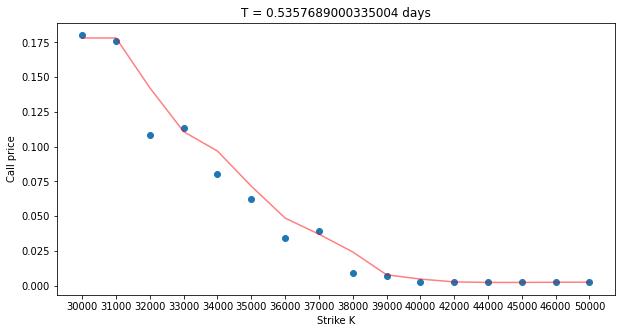

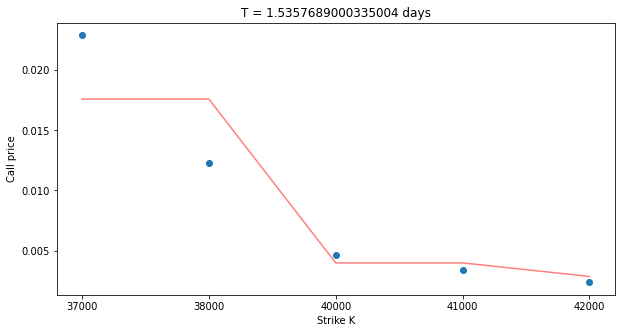

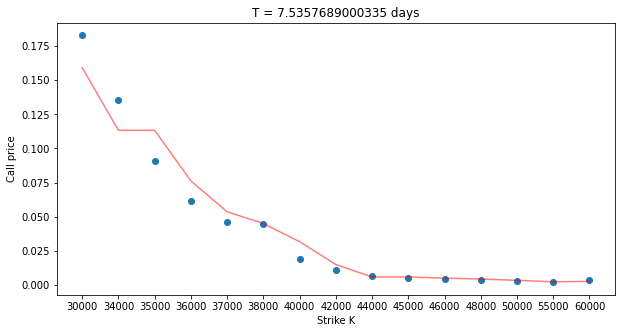

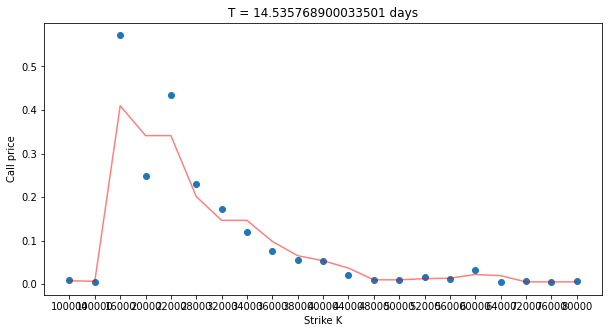

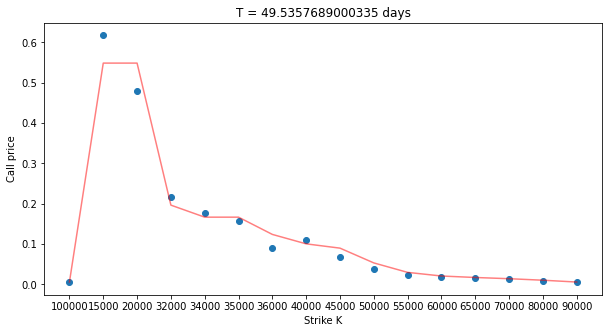

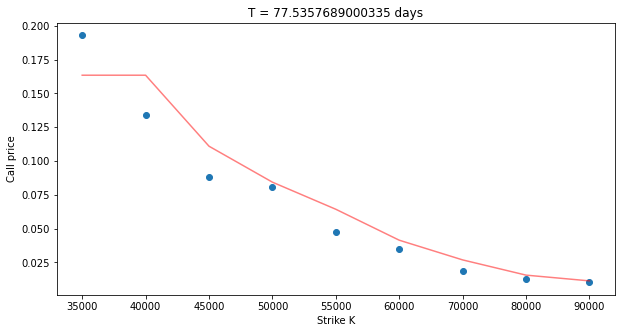

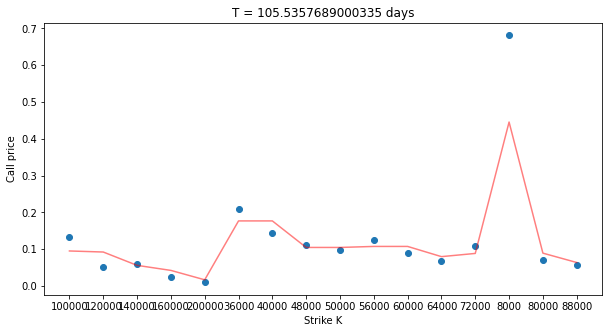

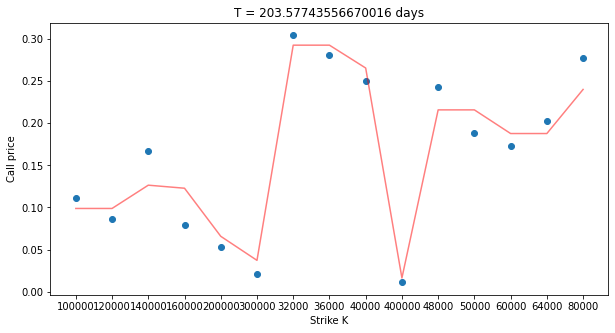

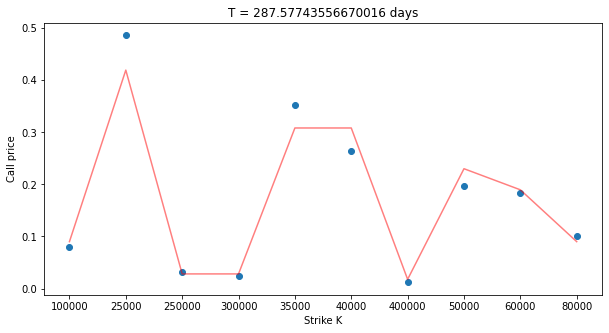

In [99]:
res = []
for i in list(btc_data.sort_values('_T')['_T']):
    if i not in res:
        res.append(i)

plt.rcParams["figure.figsize"] = (10,5)

for T in res:
    
    #plt.plot(btc_data[btc_data._T == T]['K'],btc_data[btc_data._T == T]['mid'])
    plt.xlabel('Strike K')
    plt.ylabel('Call price')
    plt.title('T = {} days'.format(T))
    
    
    
    btc_knn = KNeighborsRegressor(n_neighbors=2)
    
    btc_knn.fit(btc_data[btc_data._T == T].K.values.reshape(-1,1),
                btc_data[btc_data._T == T].mid.values.reshape(-1,1))


    btc_smoothed_fit = btc_knn.predict(btc_data[btc_data._T == T].K.values.reshape(-1,1))
    
    plt.plot(btc_data[btc_data._T == T].K, btc_smoothed_fit, c='r', alpha=0.50, label='KNN Fit')
    
    plt.scatter(btc_data[btc_data._T == T].K, btc_data[btc_data._T == T].mid) #label='Mid Implied Volatility')
    plt.show()

    


On observe un certain nombre de points aberrants, je suppose que cela vient de la trop faible liquidité pour ces contrats, nous allons donc faire un traitement pour exclure les rows trop peu liquides.